# Lecture 05  
### Introduction to Cython - Part 02
### Feb 21, 2024   

---

Based on the material https://nyu-cds.github.io/python-cython/

This lecture provides a very brief introduction to Cython. See the [Cython documentation](http://cython.readthedocs.io/en/latest/) for a more detailed description of the Cython language.

----
## Cython for NumPy Users
NumPy can be used from Cython in exactly the same manner as in regular Python, however Cython also has a number of features that support fast access to NumPy arrays that can result in significant performance gains.

### Convolution -- Example Image Convolution 



Image processing uses convolution of an input image and corresponding kernel for blurring, sharpening, embossing, edge detection, etc. 

https://en.wikipedia.org/wiki/Kernel_(image_processing)


#### Convolution of two functions: $f \star g$

Discrete, on $\mathbf{Z}$: $$(f \star g) [n] = \sum_k f[k] g[n-k]$$

Continuous, on $\mathbf{R}$: $$(f \star g) (x) = \int f(t) g(x-t) d t $$

Continuous, on $\mathbf{R}^2$: $$(f \star g) (\vec{z}) = \iint f(\vec{u}) g(\vec{z}-\vec{u}) d \vec{u}$$




<!-- ![](https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif) -->
<img src="https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif" alt="Drawing" style="width: 200px;"/>

- The code below does 2D discrete convolution of an image with a filter.

In [8]:
# Pure python code
import numpy as np

def naive_convolve(f, g):   
    # f is an image and is indexed by (i, j)
    # g is a filter kernel and is indexed by (x, y); it needs odd dimensions
    # h is the output image and is indexed by (i, j)
    
    if g.shape[0] % 2 != 1 or g.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")
    
    # dimensions of the image and filter
    (fx_max, fy_max) = f.shape
    (gx_max, gy_max) = g.shape
    
    # allocate the result image
    h = np.zeros([fx_max, fy_max], dtype=float)
    
    # do convolution
    for i in range(fx_max):
        for j in range(fy_max):
            # Calculate the pixel value h(i,j)             
            value = 0
            for x in range(0, min(i, gx_max)):
                for y in range(0, min(j, gy_max)):
                    value += g[x, y] * f[i - x, j - y]
            h[i, j] = value
    return h

689 ms ± 38.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


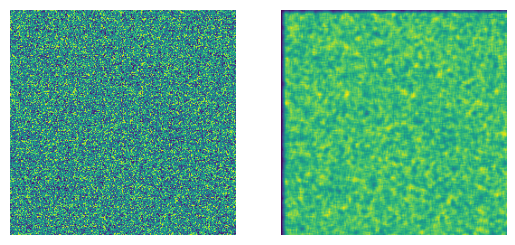

In [9]:
from matplotlib import pyplot as plt

I = np.random.uniform(low=0, high=1.0, size=((250, 250)))
G = np.ones((5, 5)) * (1/25)

%timeit naive_convolve(I, G)
H = naive_convolve(I, G)

plt.subplot(1, 2, 1)
plt.imshow(I)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(H)
plt.axis('off')

plt.show()

As we saw previously, we can simply compile this code using Cython and expect some performance improvements. Let’s copy the naive_convolve function from the cell above, then rename the function convolve1 and compile it with Cython.

In [10]:
# using cython (the following code is identical to the previous on)
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [11]:
%%cython

# Pure python code
import numpy as np

def naive_convolve_cython(f, g):   
    # f is an image and is indexed by (i, j)
    # g is a filter kernel and is indexed by (x, y); it needs odd dimensions
    # h is the output image and is indexed by (i, j)
    
    if g.shape[0] % 2 != 1 or g.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")
    
    # dimensions of the image and filter
    (fx_max, fy_max) = f.shape
    (gx_max, gy_max) = g.shape
    
    # allocate the result image
    h = np.zeros([fx_max, fy_max], dtype=float)
    
    # do convolution
    for i in range(fx_max):
        for j in range(fy_max):
            # Calculate the pixel value h(i,j)             
            value = 0
            for x in range(0, min(i, gx_max)):
                for y in range(0, min(j, gy_max)):
                    value += g[x, y] * f[i - x, j - y]
            h[i, j] = value
    return h

575 ms ± 31.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


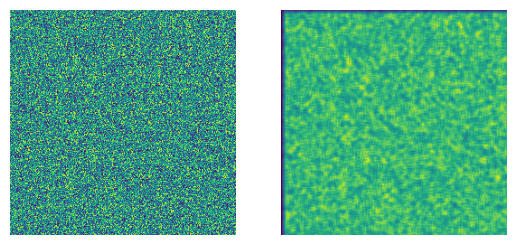

In [5]:
from matplotlib import pyplot as plt

Ic = np.random.uniform(low=0, high=1.0, size=((250, 250)))
Gc = np.ones((5, 5)) * (1/25)
%timeit naive_convolve_cython(Ic, Gc)
Hc = naive_convolve_cython(Ic, Gc)

plt.subplot(1, 2, 1)
plt.imshow(Ic)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Hc)
plt.axis('off')

plt.show()

- The next step is to add Cython data types to the code. This code will no longer be compatible with Python, so the consequences of doing this must be carefully considered. 
- The most important change is to use variables that have the same data type as the elements of the NumPy arrays.
- For normal variables, this simply means adding a line like *cdef type variable* (where *type* is the appropriate C type) for each variable in the program. 
- Since it is also possible to initialize the variable at the same time it is declared, we can simplify the code by declaring it the first time it is used. 
- In the *naive_convolve_cython* case above, we know that the indices of the NumPy arrays are integers, so we can do something like:

In [1]:
# compiling with cython using ctypes
%load_ext Cython

In [2]:
%%cython --annotate
import numpy as np
cimport numpy as np # need to import special compile-time information

def naive_convolve_cython_with_ctypes(np.ndarray f, np.ndarray g): # the arrays type are provided
    # f is an image and is indexed by (i, j)
    # g is a filter kernel and is indexed by (x, y); it needs odd dimensions
    # h is the output image and is indexed by (i, j)
    
    if g.shape[0] % 2 != 1 or g.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")
    
    # dimensions of the image and filter
    # the variables are stated now using cdef
    cdef int fx_max = f.shape[0]
    cdef int fy_max = f.shape[1]
    cdef int gx_max = g.shape[0]
    cdef int gy_max = g.shape[1]
    
    # stating the type of the variables in for-loops allows 
    # for a more optimized conversion to a C loop
    cdef int i  
    cdef int j
    cdef int x
    cdef int y
    cdef double value

    # allocate the result image
    cdef np.ndarray h = np.zeros([fx_max, fy_max], dtype=float)
    
    # do convolution
    for i in range(fx_max):
        for j in range(fy_max):
            # Calculate the pixel value h(i,j)             
            value = 0
            for x in range(0, min(i, gx_max)):
                for y in range(0, min(j, gy_max)):
                    value += g[x, y] * f[i - x, j - y]
            h[i, j] = value
    return h

Content of stdout:
_cython_magic_ed1015c7923e5f3c8b1af9326a0e87b9fe244fad.c
d:\Program_Files\Anaconda3\lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\alexm\.ipython\cython\_cython_magic_ed1015c7923e5f3c8b1af9326a0e87b9fe244fad.c(4457): warning C4244: "=": ?"npy_intp"???"int",??????
C:\Users\alexm\.ipython\cython\_cython_magic_ed1015c7923e5f3c8b1af9326a0e87b9fe244fad.c(4467): warning C4244: "=": ?"npy_intp"???"int",??????
C:\Users\alexm\.ipython\cython\_cython_magic_ed1015c7923e5f3c8b1af9326a0e87b9fe244fad.c(4477): warning C4244: "=": ?"npy_intp"???"int",??????
C:\Users\alexm\.ipython\cython\_cython_magic_ed1015c7923e5f3c8b1af9326a0e87b9fe244fad.c(4487): warning C4244: "=": ?"npy_intp"???"int",??????
  ????? C:\Users\alexm\.ipython\cython\Users\alexm\.ipython\cython\_cython_magic_ed1015c7923e5f3c8b1af9326a0e87b9fe244fad.cp310-win_amd64.lib ??? C:

445 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


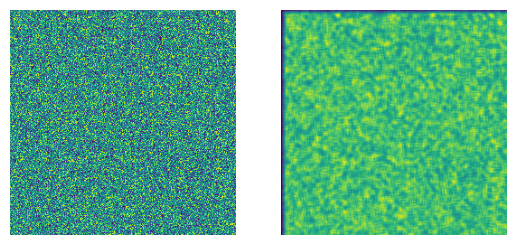

In [14]:
from matplotlib import pyplot as plt

Ict = np.random.uniform(low=0, high=1.0, size=((250, 250)))
Gct = np.ones((5, 5))* (1/25)
%timeit naive_convolve_cython_with_ctypes(Ict,Gct)
Hct = naive_convolve_cython_with_ctypes(Ict,Gct)

plt.subplot(1, 2, 1)
plt.imshow(Ict)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Hct)
plt.axis('off')

plt.show()

### Efficient Indexing

- Still a bottleneck: the array lookups and assignments. 

- The [ ]-operator still uses full Python operations.

- It would be much more effient if we could access the data buffer directly at C speed.

- It is possible to do this by specifying the type the **_contents** of the **_ndarray** objects.

- We do this with a special “buffer” syntax which must be told:

- (i) the datatype (first argument), and 

- (ii) number of dimensions (“ndim” keyword-only argument, if not provided then one-dimensional is assumed).


- The format for this syntax is: *np.ndarray[type, ndim=N]*

- Here, type is the compile-time type of the array elements, and N is the number of dimensions in the array. This syntax is used wherever an ndarray is declared.

In [15]:
# compiling with cython typing the content of ndarray objects
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [16]:
%%cython
import numpy as np
cimport numpy as np # need to import special compile-time information
# cimport cython

# @cython.boundscheck(False)
def naive_convolve_cython_with_ctypes_and_typing_ndarray(np.ndarray[double, ndim=2] f, 
                                                         np.ndarray[double, ndim=2] g): 
    # the arrays type are provided
    # f is an image and is indexed by (i, j)
    # g is a filter kernel and is indexed by (x, y); it needs odd dimensions
    # h is the output image and is indexed by (i, j)
    
    if g.shape[0] % 2 != 1 or g.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")
    
    # dimensions of the image and filter
    # the variables are stated now using cdef
    cdef int fx_max = f.shape[0]
    cdef int fy_max = f.shape[1]
    cdef int gx_max = g.shape[0]
    cdef int gy_max = g.shape[1]
    
    # stating the type of the variables in for-loops allows 
    # for a more optimized conversion to a C loop
    cdef int i  
    cdef int j
    cdef int x
    cdef int y
    cdef double value

    # allocate the result image
    cdef np.ndarray[double, ndim=2] h = np.zeros([fx_max, fy_max], dtype=float)
    
    # do convolution
    for i in range(fx_max):
        for j in range(fy_max):
            # Calculate the pixel value h(i,j)            
            value = 0
            for x in range(0, min(i, gx_max)):
                for y in range(0, min(j, gy_max)):
                    value += g[x, y] * f[i - x, j - y]
            h[i, j] = value
    return h

4.46 ms ± 59.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


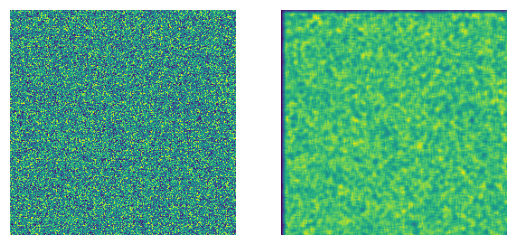

In [17]:
from matplotlib import pyplot as plt

Ictt = np.random.uniform(low=0, high=1.0, size=((250, 250))).astype(float)
Gctt = (np.ones((5, 5)) * (1/25)).astype(float)

%timeit naive_convolve_cython_with_ctypes_and_typing_ndarray(Ictt,Gctt)
Hctt = naive_convolve_cython_with_ctypes_and_typing_ndarray(Ictt,Gctt)

plt.subplot(1, 2, 1)
plt.imshow(Ictt)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(Hctt)
plt.axis('off')

plt.show()